In [1]:
import numpy as np
from cellpose import plot, utils, io
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, regionprops_table
from skimage.segmentation import clear_border
from numpy.polynomial.polynomial import polyfit
import glob

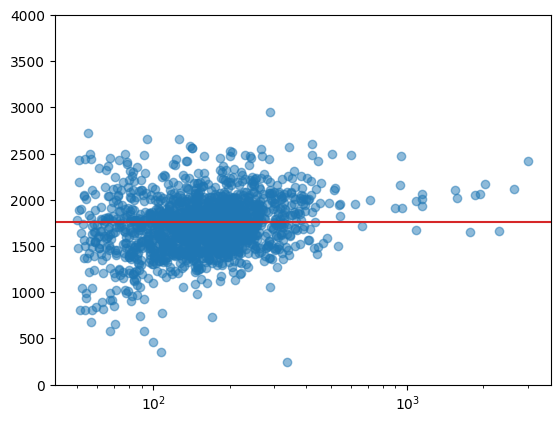

In [138]:
pixelX = 2138
micronX = 212.13
pix_to_um = micronX/pixelX

means = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Ap4*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        )
    means.append(props["intensity_mean"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2
    vols.append(v*pix_to_um**3)

means = np.concatenate(means)
vols = np.concatenate(vols)

is_cell_sized = vols>50 
plt.scatter(vols[is_cell_sized], means[is_cell_sized], alpha=0.5)
#b, m = polyfit(vols[is_cell_sized], means[is_cell_sized], 1)
plt.axhline(np.mean(means), color="C03")
plt.ylim(0, 4000)
plt.xscale("log")

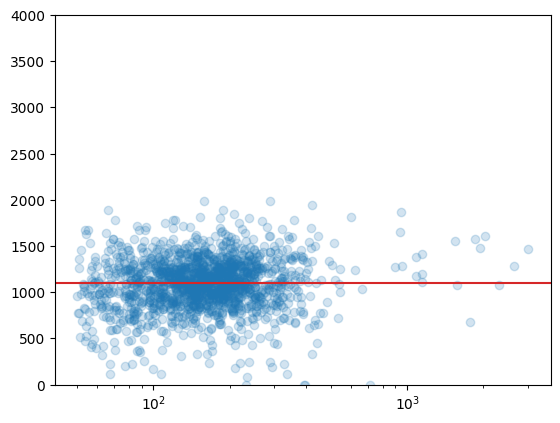

In [140]:
pixelX = 2138
micronX = 212.13
pix_to_um = micronX/pixelX

def get_median(m, im):
    return np.median(im)

meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Ap4*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds)
vols = np.concatenate(vols)

is_cell_sized = vols>50 
plt.scatter(vols[is_cell_sized], meds[is_cell_sized], alpha=0.2)
#b, m = polyfit(vols[is_cell_sized], means[is_cell_sized], 1)
plt.axhline(np.mean(meds), color="C03")
plt.ylim(0, 4000)
plt.xscale("log")

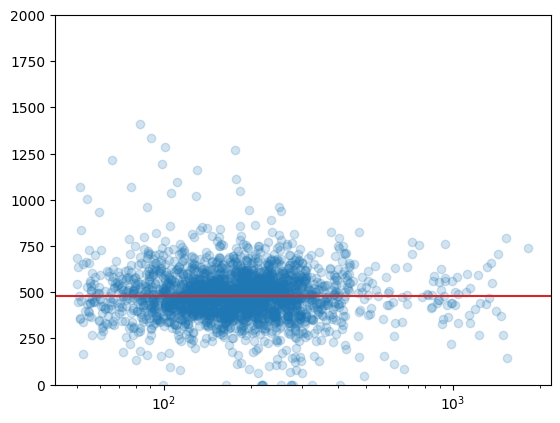

In [147]:
pixelX = 2138
micronX = 212.13
pix_to_um = micronX/pixelX

def get_median(m, im):
    return np.median(im)

meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Ap5*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds)
not_af = meds<1500
meds = meds[not_af]
vols = np.concatenate(vols)[not_af]

is_cell_sized = vols>50 
plt.scatter(vols[is_cell_sized], meds[is_cell_sized], alpha=0.2)
#b, m = polyfit(vols[is_cell_sized], means[is_cell_sized], 1)
plt.axhline(np.median(meds), color="C03")
plt.ylim(0, 2000)
plt.xscale("log")

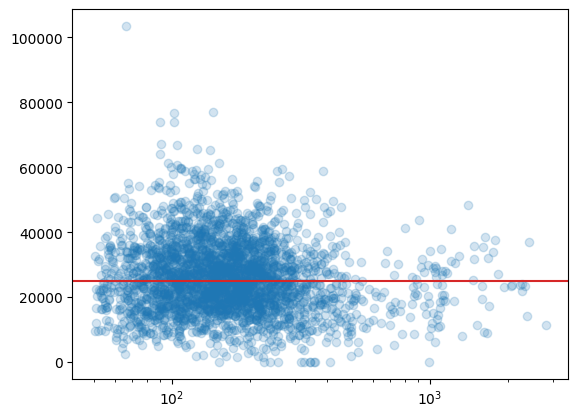

In [151]:
pixelX = 2138
micronX = 212.13
pix_to_um = micronX/pixelX

def get_median(m, im):
    return np.median(im)

meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Ap6*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds)*(50/3) #Used wrong setting for this aquisition. Normalizing to counts from FCS.
#not_af = meds<1500
#meds = meds[not_af]
vols = np.concatenate(vols)#[not_af]

is_cell_sized = vols>50 
plt.scatter(vols[is_cell_sized], meds[is_cell_sized], alpha=0.2)
#b, m = polyfit(vols[is_cell_sized], means[is_cell_sized], 1)
plt.axhline(np.median(meds), color="C03")
plt.ylim(0, 8000)
plt.xscale("log")

(0.0, 5000.0)

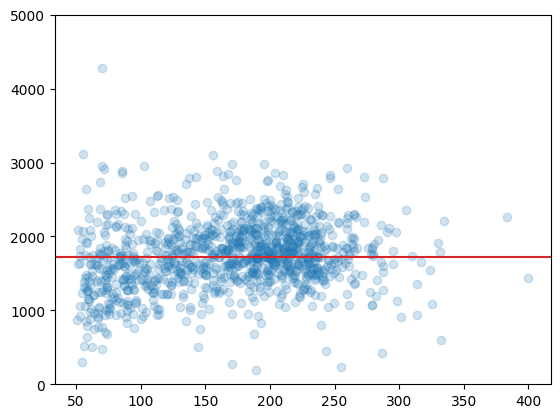

In [159]:
pixelX = 2138
micronX = 212.13
pix_to_um = micronX/pixelX

def get_median(m, im):
    return np.median(im)

meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Sc2*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds)*2
not_af = meds<5000
meds = meds[not_af]
vols = np.concatenate(vols)[not_af]

is_cell_sized = vols>50 
plt.scatter(vols[is_cell_sized], meds[is_cell_sized], alpha=0.2)
#b, m = polyfit(vols[is_cell_sized], means[is_cell_sized], 1)
plt.axhline(np.median(meds), color="C03")
plt.ylim(0, 5000)

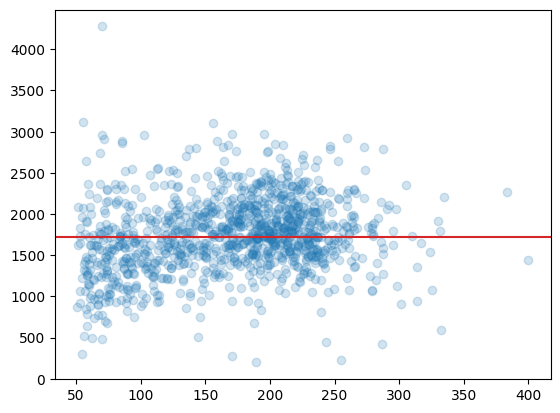

In [166]:
pixelX = 2138
micronX = 212.13
pix_to_um = micronX/pixelX

def get_median(m, im):
    return np.median(im)

meds = []
vols = []
for f in glob.glob("../data/2024_09_10-NiceImgs/Sc2*.npy"):
    dat = np.load(f, allow_pickle=True).item()
    labels = dat["masks"]
    img = io.imread(f.replace("_seg.npy", ".tif"))
    props = regionprops_table(
        labels, img,
        properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
        extra_properties=(get_median,)
        )
    meds.append(props["get_median"])
    v = props["axis_major_length"] * props["axis_minor_length"]**2
    vols.append(v*pix_to_um**3)

meds = np.concatenate(meds)*2
not_af = meds<5000
meds = meds[not_af]
vols = np.concatenate(vols)[not_af]

is_cell_sized = vols>50 
plt.scatter(vols[is_cell_sized], meds[is_cell_sized], alpha=0.2)
#b, m = polyfit(vols[is_cell_sized], means[is_cell_sized], 1)
plt.axhline(np.median(meds), color="C03")
#plt.ylim(0, 5000)

In [168]:
dat = np.load('../data/2024_09_10-NiceImgs/Ap4_confocal-1_seg.npy', allow_pickle=True).item()
img = io.imread('../data/2024_09_10-NiceImgs/Ap4_confocal-1.tif')
labels = dat["masks"]
props = regionprops_table(
    labels, img,
    properties=('intensity_mean', 'axis_major_length', 'axis_minor_length'),
)

In [174]:
np.median(img.ravel())

187.0

(0.0, 4000.0)

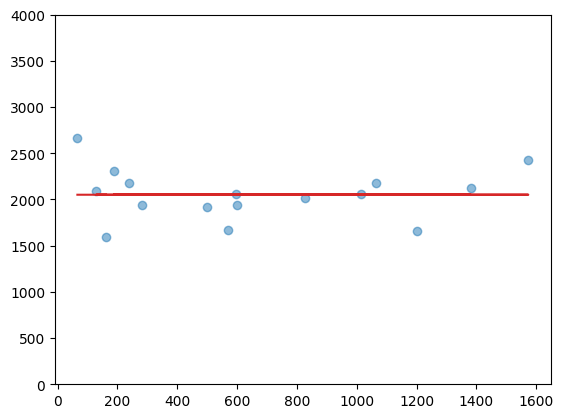

In [87]:
means = props["intensity_mean"]
vols = props["axis_major_length"] * props["axis_minor_length"]**2 * (4/3)*(0.5**3)*np.pi
vols = vols*pix_to_um**3
is_cell_sized = vols>50
plt.scatter(vols[is_cell_sized], means[is_cell_sized], alpha=0.5)
b, m = polyfit(vols[is_cell_sized], means[is_cell_sized], 1)
plt.plot(vols[is_cell_sized], b + np.multiply(vols[is_cell_sized],m), color="C03")
plt.ylim(0, 4000)

In [97]:
np.concatenate([means,means])

array([2661.3282892 , 2122.5861173 , 1671.09561548, 2307.23174157,
       1935.30564821, 2058.99618063, 2061.71988143, 2014.92975734,
       2425.76958525, 1914.57074207, 1662.12662651, 1945.05522289,
       2183.32937434, 2173.83669429, 2087.66743317, 1598.5687751 ,
       2661.3282892 , 2122.5861173 , 1671.09561548, 2307.23174157,
       1935.30564821, 2058.99618063, 2061.71988143, 2014.92975734,
       2425.76958525, 1914.57074207, 1662.12662651, 1945.05522289,
       2183.32937434, 2173.83669429, 2087.66743317, 1598.5687751 ])

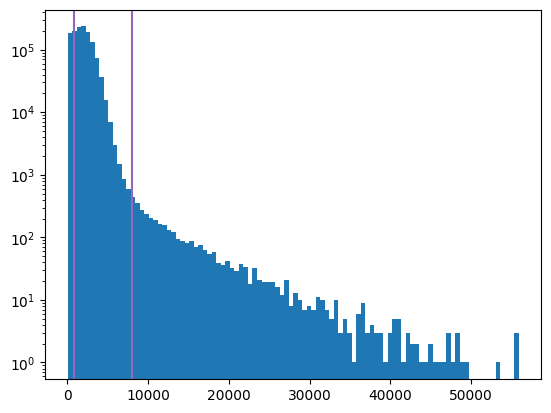

In [25]:
all_masked = img[dat["masks"]>0]
plt.hist(img[dat["masks"]>0], bins=100)
plt.yscale("log")
plt.axvline(800, color="C04")
plt.axvline(8000, color="C04")

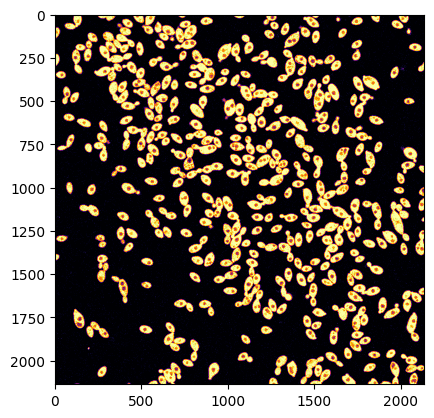

In [31]:
plt.imshow(img>800, cmap="inferno")

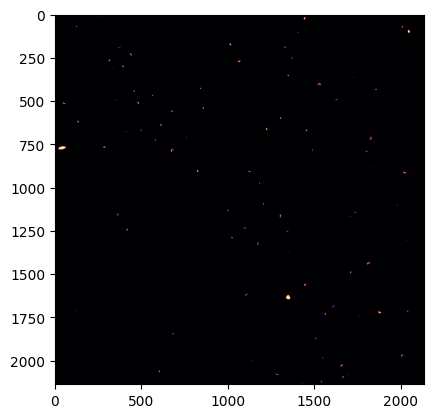

In [32]:
plt.imshow(img>8000, cmap="inferno")

(0.0, 4000.0)

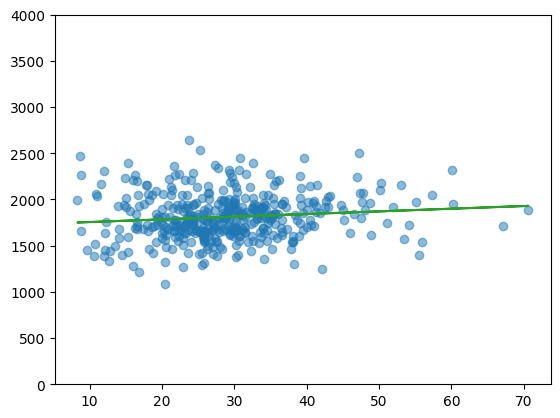

In [40]:
meds = []
pixels = []
for n in np.unique(clear_border(dat["masks"])):
    if n == 0:
        pass
    else:
        mask = dat["masks"] == n
        cell = img[mask]
        px = len(cell.ravel())
        if px > 800:
            pixels.append(px)
            meds.append(np.median(cell))
#plt.hist(meds, bins=100)
#plt.hist(pixels, bins=100)

sq_microns = np.multiply(pixels,pix_area)
plt.scatter(sq_microns, meds, alpha=0.5)
b, m = polyfit(sq_microns, meds, 1)
plt.plot(sq_microns, b + np.multiply(sq_microns,m), color="C02")
plt.ylim(0, 4000)

(0.0, 4000.0)

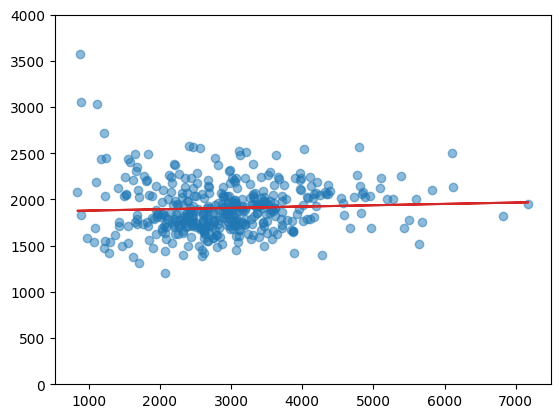

In [95]:
means = []
pixels = []
for n in np.unique(clear_border(dat["masks"])):
    if n == 0:
        pass
    else:
        mask = dat["masks"] == n
        cell = img[mask]
        px = len(cell.ravel())
        if px > 800:
            pixels.append(px)
            means.append(np.mean(cell))
#plt.hist(meds, bins=100)
#plt.hist(pixels, bins=100)
plt.scatter(pixels, means, alpha=0.5)

b, m = polyfit(pixels, means, 1)
plt.plot(pixels, b + np.multiply(pixels,m), color="C03")
plt.ylim(0, 4000)

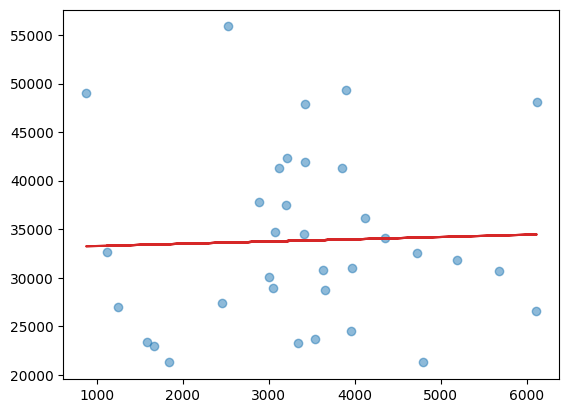

In [106]:
maxes = []
pixels = []
for n in np.unique(clear_border(dat["masks"])):
    if n == 0:
        pass
    else:
        mask = dat["masks"] == n
        cell = img[mask]
        px = len(cell.ravel())
        if px > 800 and np.max(cell) > 20000:
            pixels.append(px)
            maxes.append(np.max(cell))
#plt.hist(meds, bins=100)
#plt.hist(pixels, bins=100)
plt.scatter(pixels, maxes, alpha=0.5)

b, m = polyfit(pixels, maxes, 1)
plt.plot(pixels, b + np.multiply(pixels,m), color="C03")
